[Data from the sc best practices online book](https://www.sc-best-practices.org/cellular_structure/integration.html#dataset)

In [ ]:
import numpy as np
import scanpy as sc
import anndata as ad
import seaborn as sns

lgdata = sc.read_h5ad('data/openproblems_bmmc_multiome_genes_filtered.h5ad')
lgdata

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

For scRNA data:
- n_obs = barcodes (cells)
- n_vars = transcripts (genes)

Since I am working on my local machine, I need to downsample this dataset for computational resources and time. 

The "obs" of this data has a lot of metadata about the samples. In the next ipynb I will be working on data integration, so I want to ensure I have multiple batches present in my downsampled data. 

In [2]:
#import pandas as pd
#pd.set_option("display.max_rows", None)

#for reproducibility and ease of use, it's helpful to 
#define variables for your batch and label
batch_key = 'batch'
label_key = 'cell_type'

lgdata.obs[batch_key].value_counts()

batch
s4d8     9876
s4d1     8023
s3d10    6781
s1d2     6740
s1d1     6224
s2d4     6111
s2d5     4895
s3d3     4325
s4d9     4325
s1d3     4279
s2d1     4220
s3d7     1771
s3d6     1679
Name: count, dtype: int64

Multiple samples were taken from different donors to create this dataset. For example "s1d2" is sample 1 from donor 2. Since I will be looking at batch effects downstream, I'm going to downsample the dataset to be different samples all from the same donor.

In [3]:
#list of batch ids to keep
keep_ids = ['s1d1', 's2d1', 's4d1']

#downsample the large dataset
smdata = lgdata[lgdata.obs[batch_key].isin(keep_ids)].copy()
smdata

AnnData object with n_obs × n_vars = 18467 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [ ]:
#save downsampled data so I don't need to load the large again
smdata.write_h5ad('smdata_same_donor.h5ad')

Just in case I want to compare later, I'm also going to save a downsampled dataset of different donors. 

In [8]:
keep_ids = ['s3d3', 's4d9', 's2d1']
diffdata = lgdata[lgdata.obs[batch_key].isin(keep_ids)].copy()

diffdata.write_h5ad('smdata_diff_donor.h5ad')

AnnData object with n_obs × n_vars = 12870 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

### Quality Control
Now that I downsampled my data, I want to get rid of any low quality cells. If a cell does not have many counts, a low number of genes, or a high fraction of mitochondrial genes it can be considered low quality. These criteria are indicative of a broken membrane and possibly a dying cell.

The scanpy function below (`sc.pp.calculate_qc_metrics`) is used to calculate quality control metrics. Since I want to know if there is a high fraction of mitochondrial genes, I will define mitochondrial genes and add in the `qc_vars` parameter. This lets scanpy know to calculate what proportion of counts in a cell are mitochondrial. 

In [2]:
#restart kernel to clear the large dataset
import numpy as np
import scanpy as sc
import anndata as ad
import seaborn as sns

#this loads in the small dataset I saved earlier
smdata = sc.read_h5ad('smdata_same_donor.h5ad')
smdata

AnnData object with n_obs × n_vars = 18467 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [3]:
#define mitochondrial genes as a var_name starting with MT-
smdata.var["mt"] = smdata.var_names.str.startswith("MT-")

#calculate QC metrics, including proportion of mitochondrial counts per cell
sc.pp.calculate_qc_metrics(smdata, qc_vars=["mt"], percent_top=[20], inplace=True)
smdata

AnnData object with n_obs × n_vars = 18467 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red'

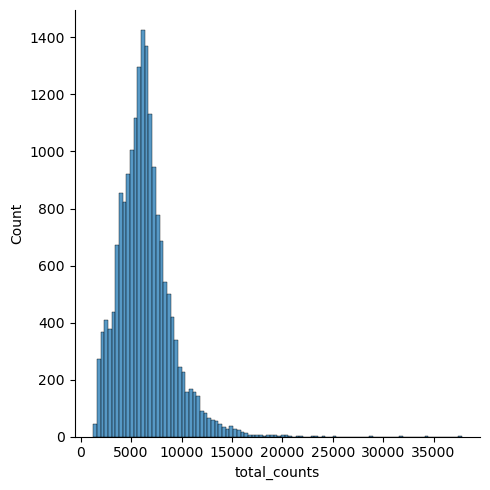

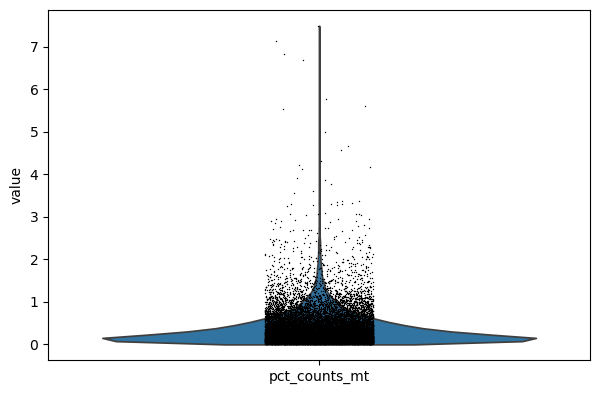

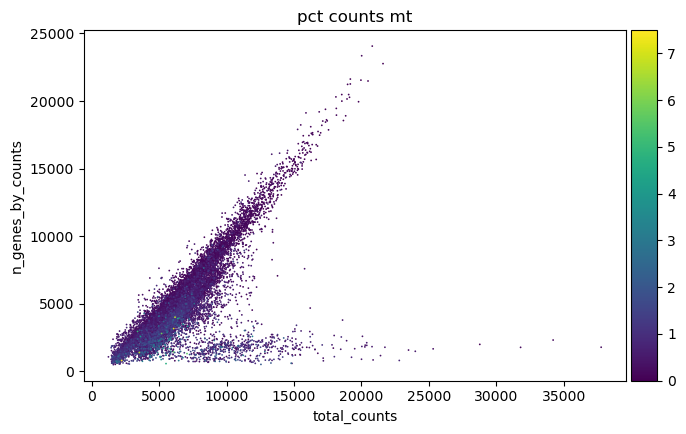

In [4]:
#create plots to visualize data
p1 = sns.displot(smdata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(smdata, "pct_counts_mt")
p3 = sc.pl.scatter(smdata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

### Visualize data

- n_genes_by_counts = number of genes with positive counts in a cell
- total_counts = total counts in a cell
- pct_counts_mt = percentage of mitochondrial counts in a cell

Note: pct_counts_mt confused me at first because many resources (including the scanpy docs) call this a "proportion". How can a proportion be greater than 1? After a lot of reading and playing with the data I realized it's a *percentage*. Here we see the mitochondrial count *percentage* goes a little above 7% (not that the proportion of mitochondrial counts is somehow 7). 

- The first graph shows we have a lot of cells with counts between 2500 and 10000.
- The second graph shows there are some cells with mitochondrial counts as high as 7%, but most are below 1%.
- The third graph shows the total counts mostly correlate to the number of genes counted in a cell, with some cells having higher counts but fewer genes (meaning certain genes must be more expressed in those cells, to give the higher overall count). Additionally the colors show most of these cells have a low percentage of mitochondrial counts and the high mitochondrial count cells do not appear to cluster in one spot.

### Filtering outliers
While you *can* look at graphs and manually decide what cutoff thresholds to use for a given dataset, this can be cumbersome when there are many datasets to go through or the datasets are very large. Following the sc best practices online book, I will use median absolute deviations (MAD) for filtering outliers. 

In [5]:
from scipy.stats import median_abs_deviation

#define a function for calculating MAD
#input is a QC metric calculated above with 'sc.pp.calculate_qc_metrics'
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [6]:
#calculate outliers based on standard QC variables
smdata.obs["outlier"] = (
    is_outlier(smdata, "log1p_total_counts", 5)
    | is_outlier(smdata, "log1p_n_genes_by_counts", 5)
    | is_outlier(smdata, "pct_counts_in_top_20_genes", 5)
)
smdata.obs.outlier.value_counts()

outlier
False    16836
True      1631
Name: count, dtype: int64

There are 1631 outliers based on total count, number of genes, and the percentage of counts that are in the top 20 genes. The threshold of 5 MADs [was found](doi:10.1186/s13059-020-02136-7) to be a good compromise between accuracy of filtering and exclusion of valid cells.

Note: 'log1p' is the log transform of the variable that follows (total counts or number of genes). The log transform is used so that cells with a high number of genes (or counts) are not disproportionately shown as having the most variability (simply because there are more counts to be variable). Basically, we want cells with fewer genes (or counts) to be able to show variability without being blown away by cells with higher numbers.

I also filter out cells with a mitochondrial percentage threshold of 3 MADs. You can also remove cells above a mitochondrial percentage, but since none of my cells had mitochondrial counts greater than 8% I don't do that here. 

In [7]:
#filter cells with mitochondrial counts above 3 MADs
smdata.obs["mt_outlier"] = is_outlier(smdata, "pct_counts_mt", 3)
smdata.obs.mt_outlier.value_counts()

mt_outlier
False    16133
True      2334
Name: count, dtype: int64

Now we use these new obs we added to our anndata object to filter out the outlier cells.

In [8]:
print(f"Total number of cells: {smdata.n_obs}")
smdata = smdata[(~smdata.obs.outlier) & (~smdata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering out low quality cells: {smdata.n_obs}")

Total number of cells: 18467
Number of cells after filtering out low quality cells: 15070


### Doublet filtering

During droplet RNA-seq, two cells might be captured in the same droplet. scanpy includes a doublet detection method called Scrublet which I use to predict doublets and filter them out of my data.

In [9]:
sc.pp.scrublet(smdata, batch_key="batch")

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [10]:
#check how many cells are likely doublets
smdata.obs.predicted_doublet.value_counts()

predicted_doublet
False    15033
True        37
Name: count, dtype: int64

In [11]:
#filter out doublets
smdata = smdata[~smdata.obs.predicted_doublet].copy()

smdata

AnnData object with n_obs × n_vars = 15033 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 

Running scrublet maxed out my computer resources even on this downsampled dataset, but luckily there is only one more step before I save the data and move on to feature selection and dimensionality reduction.

### Normalization

The final step is normalizing the data. Each quality control step alters the data and could add spurious variability to the counts and gene expression. Normalization adjusts the data to account for sampling effects we may have introduced. Additionally, many statistical methods require normalized data. 

In [13]:
#save count data
smdata.layers["counts"] = smdata.X.copy()

#normalize to median total counts
sc.pp.normalize_total(smdata)
#log transform the data
sc.pp.log1p(smdata)

In [14]:
#write filtered data to new file
smdata.write_h5ad('smdata_same_donor_qc_done.h5ad')